# Clustering + Random Forest Regression 
### World Food Program Disaster Relief -

*@XavierTorres*

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import math

In [2]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score,mean_squared_error, mean_squared_log_error, explained_variance_score
from sklearn.metrics import mean_absolute_error, median_absolute_error
from warnings import simplefilter
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture

In [3]:
df0 = pd.read_csv(r'Data_input/OUTPUT_WBI_exposer_cyclones_v14.csv', sep=";")

## Data pre-processing

In [4]:
df0.shape

(991, 51)

In [5]:
df0.columns

Index(['SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'COORDS_MAX_WINDS',
       'COORDS_MIN_DIST2LAND', 'BASIN', 'SUB BASIN', 'MONTH_START',
       'MONTH_END', 'DATE_START', 'DATE_END', 'DATE_LAND_START',
       'DATE_LAND_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'NATURE',
       'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN',
       'DISTANCE_TRACK', 'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP',
       '96KN_POP', '64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 'POP_DEN_SQ_KM', 'RURAL_POP(%)',
       'HDI', 'Arable land (hectares per person)',
       'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final'

In [6]:
#Let's create a copy for the dataset and make changes
df = df0.copy()

In [7]:
# Arranging columns and deleting 'SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'COORDS_MAX_WINDS','BASIN', 
#'COORDS_MIN_DIST2LAND','MONTH_END', 'DATE_START', 'DATE_END', 'DATE_LAND_START','DATE_LAND_END', 'DISTANCE_TRACK',
# '34KN_POP', '64KN_POP','96KN_POP', '64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS','TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS',
# 'Net flows from UN agencies US$',

df = df[[
    # cols from cyclones
 'SUB BASIN', 'MONTH_START',
        'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'NATURE',
       'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN',
        'DISTANCE_TRACK_VINCENTY',  

    # cols from World Bank Indicators:           
'POP_DEN_SQ_KM', 'RURAL_POP(%)',
       'HDI', 'Arable land (hectares per person)',
       'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
        'Income_level_Final',
    
    # cols from climada:   
        'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ','POP_MAX_64_ADJ',
    
    # Target 
    'TOTAL_AFFECTED']]

In [8]:
df.head(3)

,SUB BASIN,MONTH_START,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,...,Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,TOTAL_AFFECTED
0,WP,6,117.0,60.0,TS,Cat 4,116.0,952,0,33.0,...,4173.5,67.79,8607.657082,67.666098,2.867878,Low,1.198300e+07,5.803981e+06,3.320907e+06,194046
1,WP,8,141.0,21.0,ET,Cat 4,116.0,940,0,31.0,...,4173.5,67.79,8607.657082,67.666098,2.867878,Low,3.160822e+07,1.559196e+07,1.018936e+07,642117
2,CS,8,15.0,3.0,TS,Cat 3,110.0,0,0,17.0,...,868.3,69.93,3796.219401,64.770000,2.578304,Low,1.689243e+06,1.687083e+06,1.195052e+06,20200


- **Checking nulls**

In [9]:
# Checking quantity of missing data. Reusing code from Fabi
def null_cols(data):

    """
    This function takes a dataframe df and shows the columns of df that have NaN values
    and the number of them

    """
    nulls = data.isna().sum()
    nulls = nulls[nulls > 0] / len(data) * 100
    nulls = pd.DataFrame(nulls.sort_values(ascending = False))
    nulls = nulls.reset_index().rename(columns = {"index": "Feature", 0: "% Null rows"})
    return nulls

In [10]:
null_cols(df)

,Feature,% Null rows
0,POP_MAX_64_ADJ,8.072654
1,POP_MAX_50_ADJ,8.072654
2,POP_MAX_34_ADJ,8.072654
3,Adjusted savings: education expenditure (% of ...,1.009082
4,Cereal yield (kg per hectare),1.009082
5,GDP per capita (constant 2010 US$),0.908174
6,"Life expectancy at birth, total (years)",0.403633
7,Food production index (2004-2006 = 100),0.403633
8,MAX_STORMSPEED,0.201816
9,Arable land (hectares per person),0.100908


- **MAX_USA_SSHS** and **MAX_USA_SSHS_INLAND** columns with value -6 = Unknown:

In [11]:
df["MAX_USA_SSHS"]= df["MAX_USA_SSHS"].replace(-6, np.nan) 
df["MAX_USA_SSHS_INLAND"]= df["MAX_USA_SSHS_INLAND"].replace('-6', np.nan) 

- **Transform 'Income_Level'** categories to ordered integers and **BASIN, SUB BASIN,NATURE and GENERAL_CATEGORY** into Category Type

In [12]:
#Arnab code
unique_list = df['Income_level_Final'].unique()
incomelevel_to_int = dict(zip(unique_list, [1,2,4,3])) # so we assign['Low' =1, 'Low_Middle' =2, 'High'=4, 'High_Middle'=3]
df['Income_level_Final'] = df['Income_level_Final'].apply(lambda inc_level: incomelevel_to_int[inc_level])

In [13]:
df['SUB BASIN'] = df['SUB BASIN'].astype('category')
df['NATURE'] = df['NATURE'].astype('category')
df['GENERAL_CATEGORY'] = df['GENERAL_CATEGORY'].astype('category')

- **Create New Column fro 'No Landing'**

In [14]:
df['Landing'] = np.where(df['MAX_USA_SSHS_INLAND'] == 'No landing', 0, 1)

In [15]:
#assign np.nan to columns with 'No landing'  value

df["MAX_USA_SSHS_INLAND"]= df["MAX_USA_SSHS_INLAND"].replace('No landing', np.nan) 

In [16]:
df["MAX_USA_SSHS_INLAND"] = df["MAX_USA_SSHS_INLAND"].astype('float')

- **One hot encoding for categorical variables**

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 29 columns):
SUB BASIN                                             991 non-null category
MONTH_START                                           991 non-null int64
TOTAL_HOURS_EVENT                                     991 non-null float64
TOTAL_HOURS_IN_LAND                                   991 non-null float64
NATURE                                                991 non-null category
GENERAL_CATEGORY                                      991 non-null category
MAX_WIND                                              991 non-null float64
MIN_PRES                                              991 non-null int64
MIN_DIST2LAND                                         991 non-null int64
MAX_STORMSPEED                                        989 non-null float64
MAX_USA_SSHS                                          990 non-null float64
MAX_USA_SSHS_INLAND                                   772 non-null float6

In [18]:
cat_feats = df.dtypes[df.dtypes == 'category'].index
cat_feats

Index(['SUB BASIN', 'NATURE', 'GENERAL_CATEGORY'], dtype='object')

In [19]:
feats_to_dummy = cat_feats #selecting feats to make one-hot encoding

for feature in feats_to_dummy:
    dummy = pd.get_dummies(df[feature], prefix=feature)
    df = pd.concat([df,dummy], axis=1)

In [20]:
# Dropping dummed features
df = df.drop(feats_to_dummy, axis=1)

In [21]:
df.columns

Index(['MONTH_START', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'MAX_WIND',
       'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED', 'MAX_USA_SSHS',
       'MAX_USA_SSHS_INLAND', 'V_LAND_KN', 'DISTANCE_TRACK_VINCENTY',
       'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'HDI',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final', 'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ',
       'POP_MAX_64_ADJ', 'TOTAL_AFFECTED', 'Landing', 'SUB BASIN_AS',
       'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS', 'SUB BASIN_EA',
       'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm', 'SUB BASIN_SI',
       'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP', 'NATURE_DS',
       'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS', 'NATURE_TS',
       'GENERAL_CATEGORY_Cat 1', '

- **Arranging columns**

In [22]:
df.shape

(991, 51)

In [23]:
#Droping Basin and keeping subBasin because has higher granularity,
#Droping '34KN_POP', '64KN_POP', '96KN_POP' as info is inherent in POP_MAX columns
#column arrangement 
df = df[[
    
     # here columns from cyclones dataset:
    'MONTH_START', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'MAX_WIND',
       'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED', 'MAX_USA_SSHS',
       'MAX_USA_SSHS_INLAND', 'V_LAND_KN', 'DISTANCE_TRACK_VINCENTY',
        'SUB BASIN_AS',
       'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS', 'SUB BASIN_EA',
       'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm', 'SUB BASIN_SI',
       'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP', 'NATURE_DS',
       'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS', 'NATURE_TS',
       'GENERAL_CATEGORY_Cat 1', 'GENERAL_CATEGORY_Cat 2',
       'GENERAL_CATEGORY_Cat 3', 'GENERAL_CATEGORY_Cat 4',
       'GENERAL_CATEGORY_Cat 5', 'GENERAL_CATEGORY_TD', 'GENERAL_CATEGORY_TS',
        'Landing',
    
         
    # here columns from World Bank Indicators dataset:
       'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'HDI',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final',
         
    #  here columns from climada:
        'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ',

    # Target   
       'TOTAL_AFFECTED']]

- Filling NaNs

In [24]:
def imput_values(data, strategy):
    """
    Returns data imputed following the strategy specified.
    Strategy can be mean, median, most_frequent
    """
    imp_trial=SimpleImputer(missing_values=np.nan, strategy=strategy)
    idata=pd.DataFrame(imp_trial.fit_transform(data))
    idata.columns=data.columns
    idata.index=data.index
    return idata

In [25]:
df = imput_values(df,"median")

In [26]:
null_cols(df)

,Feature,% Null rows


- Features and target

In [27]:
features = [   
    
    'MONTH_START', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'MAX_WIND',
       'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED', 'MAX_USA_SSHS',
       'MAX_USA_SSHS_INLAND', 'V_LAND_KN', 'DISTANCE_TRACK_VINCENTY',
        'SUB BASIN_AS',
       'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS', 'SUB BASIN_EA',
       'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm', 'SUB BASIN_SI',
       'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP', 'NATURE_DS',
       'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS', 'NATURE_TS',
       'GENERAL_CATEGORY_Cat 1', 'GENERAL_CATEGORY_Cat 2',
       'GENERAL_CATEGORY_Cat 3', 'GENERAL_CATEGORY_Cat 4',
       'GENERAL_CATEGORY_Cat 5', 'GENERAL_CATEGORY_TD', 'GENERAL_CATEGORY_TS',
        'Landing',
    
         
    # here columns from World Bank Indicators dataset:
       'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'HDI',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final',
         
    #  here columns from climada:
        'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ'
         ]

In [28]:
target = ['TOTAL_AFFECTED']

## Clustering of data points without targete variable

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [30]:
df_clust = df.copy()

In [31]:
df_clust = df_clust[features]

In [32]:
df_clust.columns

Index(['MONTH_START', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'MAX_WIND',
       'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED', 'MAX_USA_SSHS',
       'MAX_USA_SSHS_INLAND', 'V_LAND_KN', 'DISTANCE_TRACK_VINCENTY',
       'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS',
       'SUB BASIN_EA', 'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm',
       'SUB BASIN_SI', 'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP',
       'NATURE_DS', 'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS',
       'NATURE_TS', 'GENERAL_CATEGORY_Cat 1', 'GENERAL_CATEGORY_Cat 2',
       'GENERAL_CATEGORY_Cat 3', 'GENERAL_CATEGORY_Cat 4',
       'GENERAL_CATEGORY_Cat 5', 'GENERAL_CATEGORY_TD', 'GENERAL_CATEGORY_TS',
       'Landing', 'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'HDI',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)',
       'Life expectancy at birth, total (years)',
      

- Standard Scaling data before applying clustering

In [33]:
scaler = StandardScaler()
df_clust_std = pd.DataFrame(scaler.fit_transform(df_clust))

In [34]:
#recovering column names
df_clust_std= df_clust_std.rename(columns = dict(zip(df_clust_std.columns, df_clust.columns), inplace = True))

In [35]:
df_clust_std.head()

,MONTH_START,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,...,Arable land (hectares per person),Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ
0,-0.640544,0.378617,1.132310,0.866135,0.093634,-0.413495,1.539430,0.641201,-0.441308,-0.029040,...,-0.373125,0.393006,-0.874018,-0.081795,-0.353187,-0.203054,-1.534670,-0.341308,-0.313021,-0.203533
1,0.082851,0.706273,0.025604,0.866135,0.006458,-0.413495,1.329995,0.641201,0.246328,-0.029040,...,-0.373125,0.393006,-0.874018,-0.081795,-0.353187,-0.203054,-1.534670,0.124832,0.052832,0.411254
2,0.082851,-1.013921,-0.485183,0.687662,-6.822303,-0.413495,-0.136047,0.641201,1.621600,-0.019762,...,-0.257244,-1.533367,-0.800847,-0.399911,-0.740526,-0.359225,-1.534670,-0.585806,-0.466901,-0.393815
3,1.529641,1.934982,0.451261,0.985116,-0.109776,-0.413495,-0.764351,1.168529,0.933964,-0.023521,...,-0.031004,-1.458765,-2.313863,-0.580856,-1.230703,-0.262457,-0.479251,-0.512868,-0.417578,-0.401001
4,-0.278846,-0.071910,-0.314921,0.687662,0.209868,-0.413495,-0.345481,0.641201,0.246328,31.462982,...,-0.031004,-1.458765,-2.313863,-0.580856,-1.230703,-0.262457,-0.479251,-0.504062,-0.425696,-0.322793


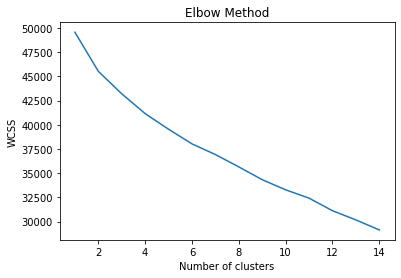

In [36]:
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_clust_std)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [37]:
# as our dataset has only near 900 observations, we select 3 clusters and check how many observations eachclustes has
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(df_clust_std)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [38]:
df_clust_std['CLUSTER'] = kmeans.labels_

In [39]:
df_clust_std.head()

,MONTH_START,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,...,Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,CLUSTER
0,-0.640544,0.378617,1.132310,0.866135,0.093634,-0.413495,1.539430,0.641201,-0.441308,-0.029040,...,0.393006,-0.874018,-0.081795,-0.353187,-0.203054,-1.534670,-0.341308,-0.313021,-0.203533,3
1,0.082851,0.706273,0.025604,0.866135,0.006458,-0.413495,1.329995,0.641201,0.246328,-0.029040,...,0.393006,-0.874018,-0.081795,-0.353187,-0.203054,-1.534670,0.124832,0.052832,0.411254,0
2,0.082851,-1.013921,-0.485183,0.687662,-6.822303,-0.413495,-0.136047,0.641201,1.621600,-0.019762,...,-1.533367,-0.800847,-0.399911,-0.740526,-0.359225,-1.534670,-0.585806,-0.466901,-0.393815,1
3,1.529641,1.934982,0.451261,0.985116,-0.109776,-0.413495,-0.764351,1.168529,0.933964,-0.023521,...,-1.458765,-2.313863,-0.580856,-1.230703,-0.262457,-0.479251,-0.512868,-0.417578,-0.401001,3
4,-0.278846,-0.071910,-0.314921,0.687662,0.209868,-0.413495,-0.345481,0.641201,0.246328,31.462982,...,-1.458765,-2.313863,-0.580856,-1.230703,-0.262457,-0.479251,-0.504062,-0.425696,-0.322793,3


________________________

## Generating a Random Forest model per each cluster

In [40]:
df['CLUSTER'] = kmeans.labels_

In [41]:
df.head()

,MONTH_START,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,...,Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,TOTAL_AFFECTED,CLUSTER
0,6.0,117.0,60.0,116.0,952.0,0.0,33.0,3.0,0.0,99.82,...,67.79,8607.657082,67.666098,2.867878,1.0,1.198300e+07,5.803981e+06,3.320907e+06,194046.0,3
1,8.0,141.0,21.0,116.0,940.0,0.0,31.0,3.0,1.0,99.82,...,67.79,8607.657082,67.666098,2.867878,1.0,3.160822e+07,1.559196e+07,1.018936e+07,642117.0,0
2,8.0,15.0,3.0,110.0,0.0,0.0,17.0,3.0,3.0,132.40,...,69.93,3796.219401,64.770000,2.578304,1.0,1.689243e+06,1.687083e+06,1.195052e+06,20200.0,1
3,12.0,231.0,36.0,120.0,924.0,0.0,11.0,4.0,2.0,119.20,...,25.68,1059.467412,61.105000,2.757732,2.0,4.760039e+06,3.006670e+06,1.114774e+06,60000.0,3
4,7.0,84.0,9.0,110.0,968.0,0.0,15.0,3.0,1.0,110691.00,...,25.68,1059.467412,61.105000,2.757732,2.0,5.130796e+06,2.789486e+06,1.988524e+06,103.0,3


- Splitting the dataset in different datasets depending on the cluster number

In [42]:
n_clusters = df['CLUSTER'].nunique()
n_clusters 

4

In [43]:
df_clust0 = df[df['CLUSTER'] == 0]
df_clust1 = df[df['CLUSTER'] == 1]
df_clust2 = df[df['CLUSTER'] == 2]
#df_clust3 = df[df['CLUSTER'] == 3]

In [44]:
df_clust0.shape, df_clust1.shape, df_clust2.shape #, df_clust3.shape

((162, 52), (221, 52), (129, 52))

In [45]:
df_clust0= df_clust0.drop('CLUSTER', axis=1)
df_clust1= df_clust1.drop('CLUSTER', axis=1)
df_clust2= df_clust2.drop('CLUSTER', axis=1)
#df_clust3= df_clust3.drop('CLUSTER', axis=1)

In [46]:
def model_validator(data, test_size, features, target):
    """
    Returns metrics and feature importances after running Random Forest algorithm
    on a dataset data, following the inputation strategy strategy, with a test size defined.
    cols is a subset of features of data without including the target variable.
    """
    
    X_i = data[features]
    y_i = data[target]
    X_itrain, X_itest, y_itrain, y_itest = train_test_split(X_i, y_i, test_size=test_size, random_state=142)
    RandomForestRegModel= RandomForestRegressor()
    model_i = RandomForestRegModel.fit(X_itrain, y_itrain)
    pred_i = model_i.predict(X_itest)
    feat_importances = pd.Series(model_i.feature_importances_, index = features)
    feat_importances.nlargest(25).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color = "slategrey",
                                       title = "Feature importance" )
    print("Metrics results:")
    print("R2 Score: {}".format(r2_score(y_itest, pred_i)))
    print("Squared root of Mean Squared Error (RMSE): {}".format(math.sqrt(mean_squared_error(y_itest, pred_i))))
    print("Mean squared logarithmic error (RMSLE): {}".format(math.sqrt(mean_squared_log_error(y_itest, pred_i))))
    print("Explained Variance: {}".format(explained_variance_score(y_itest, pred_i)))
    print("Mean Absolute Error (MAE): {}".format(mean_absolute_error(y_itest, pred_i, pred_i)))
    print("Median Absolute Error: {}".format(median_absolute_error(y_itest, pred_i)))
    
     ##################### Plotting results #########################
    df_y = pd.DataFrame(y_itest) 
    
    # Visualising the Random Forest Regression results  
    df_y['Pred_Total_Affected'] = pred_i 
    df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
    df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
    plt.figure(figsize=(12,8))
    plt.plot(df_y['TOTAL_AFFECTED'], df_y['TOTAL_AFFECTED'], '--', label = 'Observed')
    plt.plot(df_y['TOTAL_AFFECTED'], df_y['Pred_Total_Affected'], 'o', label = 'Predicted')

    plt.xlabel('(Pred_Total_Affected)')
    plt.ylabel('(Num_Affected)')
    #plt.xlim(0,100)
    plt.title('(Num Affected) - Test Vs Predictions')

    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()

C:\Users\torre\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


Metrics results:
R2 Score: -0.7099673560137612
Squared root of Mean Squared Error (RMSE): 716963.2190640329
Mean squared logarithmic error (RMSLE): 3.7174408153236547
Explained Variance: -0.6803195876718027
Mean Absolute Error (MAE): 999720.3284751234
Median Absolute Error: 55587.05


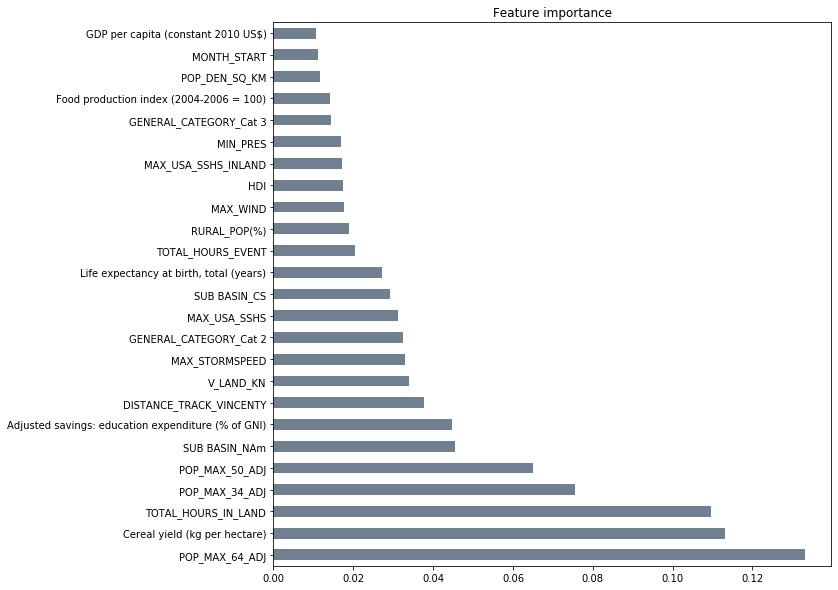

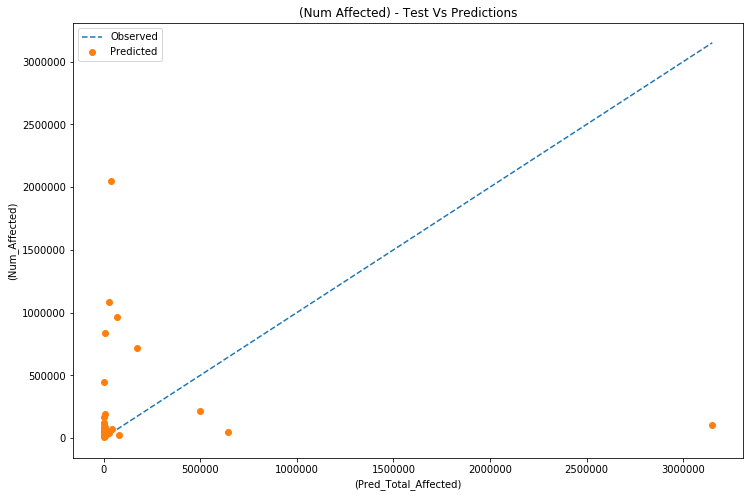

In [47]:
model_validator(df_clust0, 0.20, features, target)

C:\Users\torre\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


Metrics results:
R2 Score: -0.6019169438280809
Squared root of Mean Squared Error (RMSE): 465347.43269765144
Mean squared logarithmic error (RMSLE): 3.2002526008038052
Explained Variance: -0.5390328541854108
Mean Absolute Error (MAE): 564145.6963512881
Median Absolute Error: 94359.59


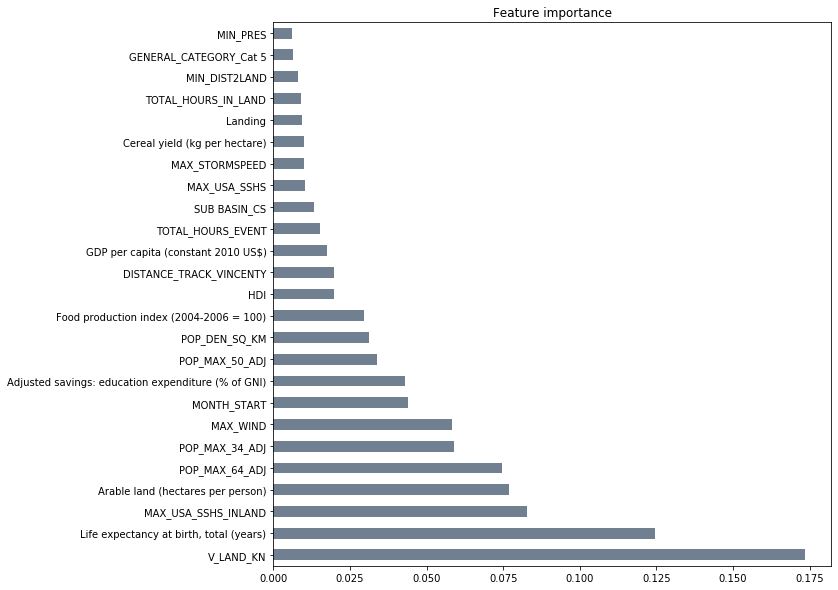

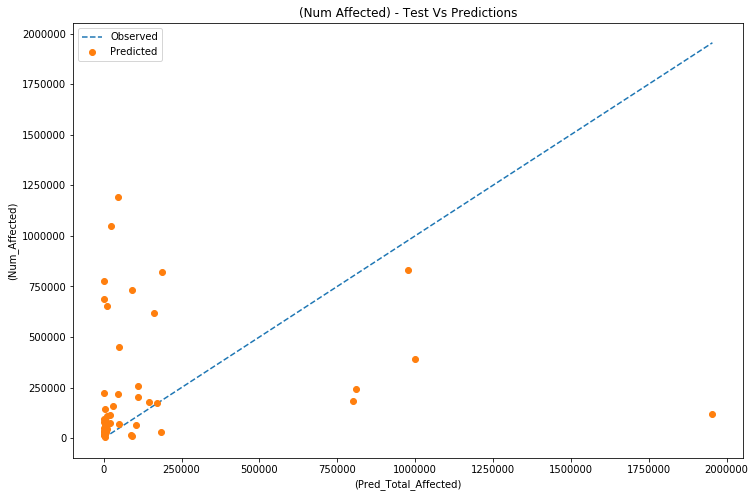

In [48]:
model_validator(df_clust1, 0.20, features, target)

C:\Users\torre\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


Metrics results:
R2 Score: -0.1769292312643609
Squared root of Mean Squared Error (RMSE): 546675.1260294514
Mean squared logarithmic error (RMSLE): 2.598449562365553
Explained Variance: -0.020104952644756757
Mean Absolute Error (MAE): 216960.02020662828
Median Absolute Error: 97410.275


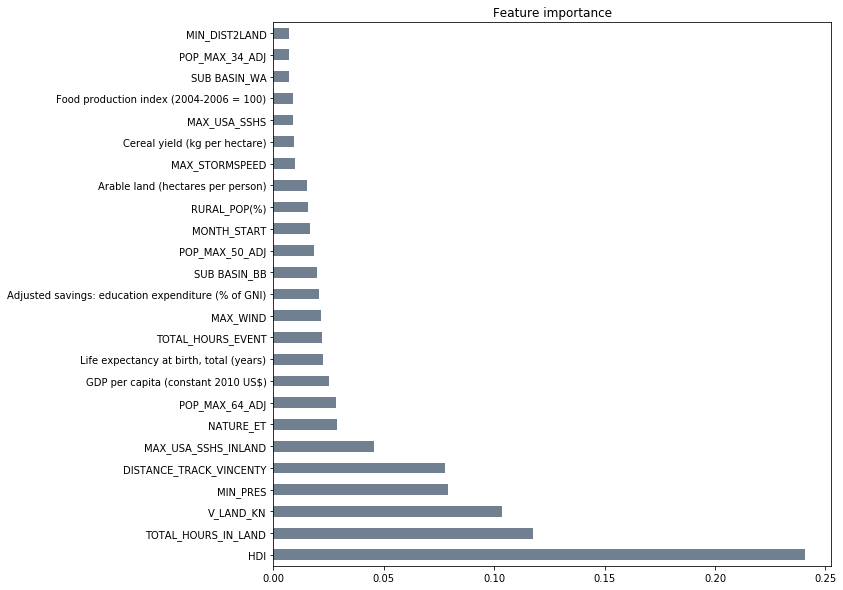

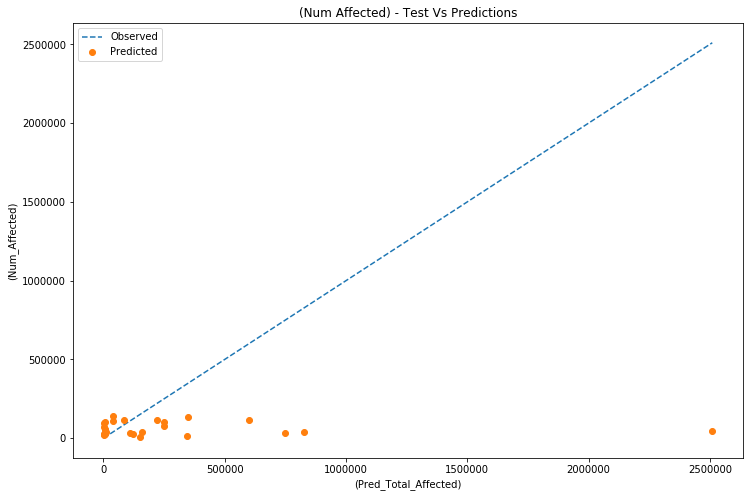

In [49]:
model_validator(df_clust2, 0.20, features, target)

C:\Users\torre\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


Metrics results:
R2 Score: -0.17486053746054964
Squared root of Mean Squared Error (RMSE): 546194.4680588602
Mean squared logarithmic error (RMSLE): 2.580622880013813
Explained Variance: -0.019212372927541743
Mean Absolute Error (MAE): 225831.7351809383
Median Absolute Error: 99706.085


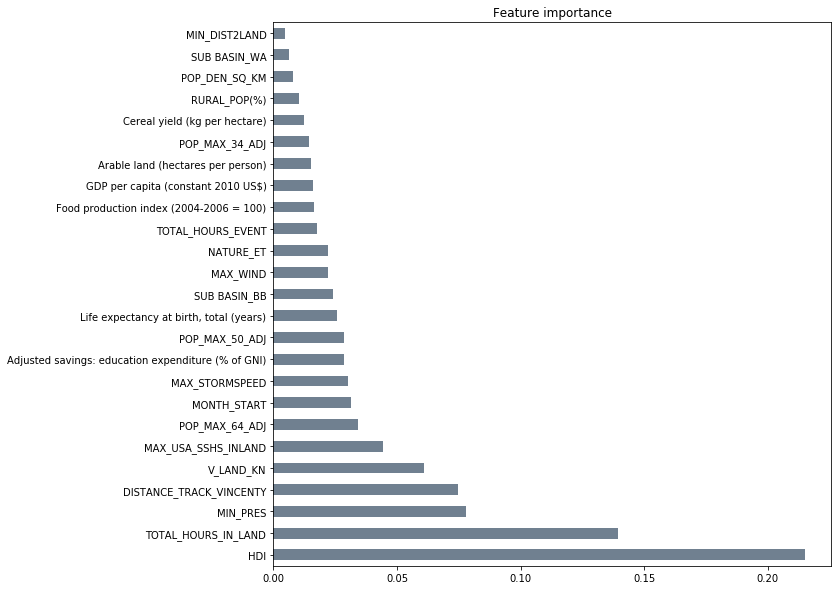

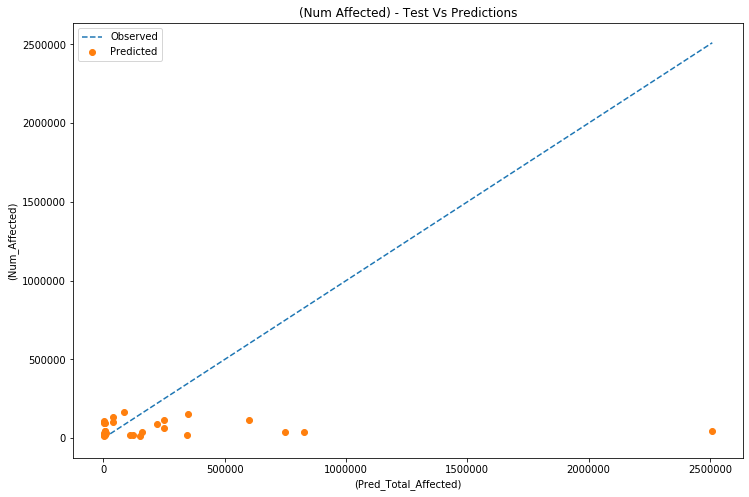

In [50]:
model_validator(df_clust2, 0.20, features, target)

In [52]:
df_total = pd.concat([df_clust0,df_clust1,df_clust2])

C:\Users\torre\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


Metrics results:
R2 Score: 0.04887282608189214
Squared root of Mean Squared Error (RMSE): 443465.1620792275
Mean squared logarithmic error (RMSLE): 3.458547776651148
Explained Variance: 0.05117258834500482
Mean Absolute Error (MAE): 485486.93717122654
Median Absolute Error: 66232.56


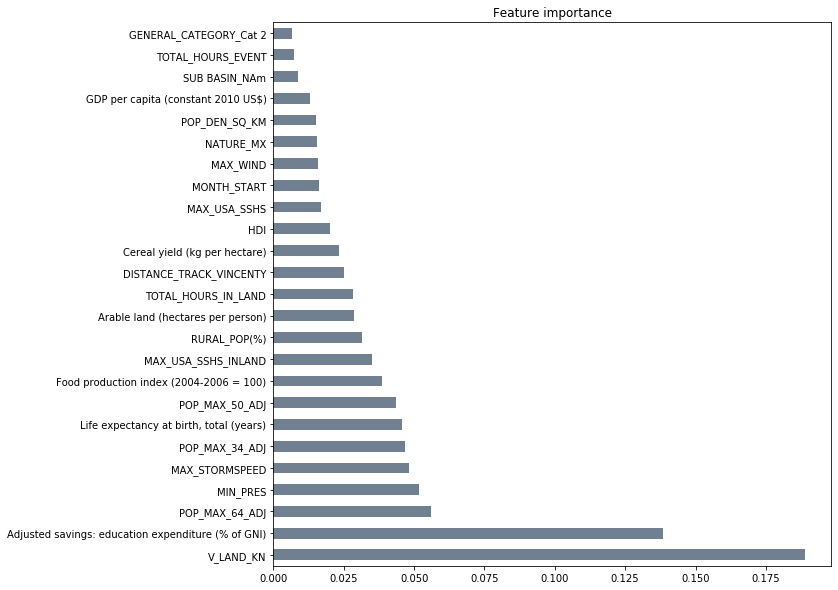

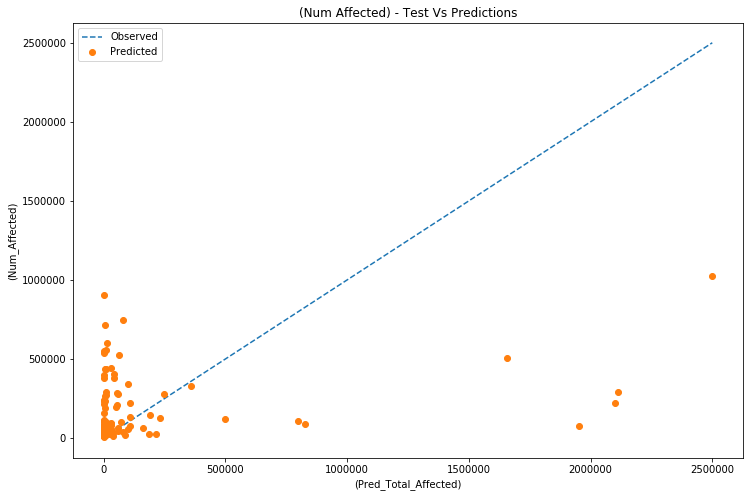

In [53]:
model_validator(df_total, 0.20, features, target)

___________________________
________________________________